In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


In [2]:
df = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')

In [3]:
df_copy = df.copy()

In [4]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
df.shape

(200, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

/tmp/ipykernel_20/102845399.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


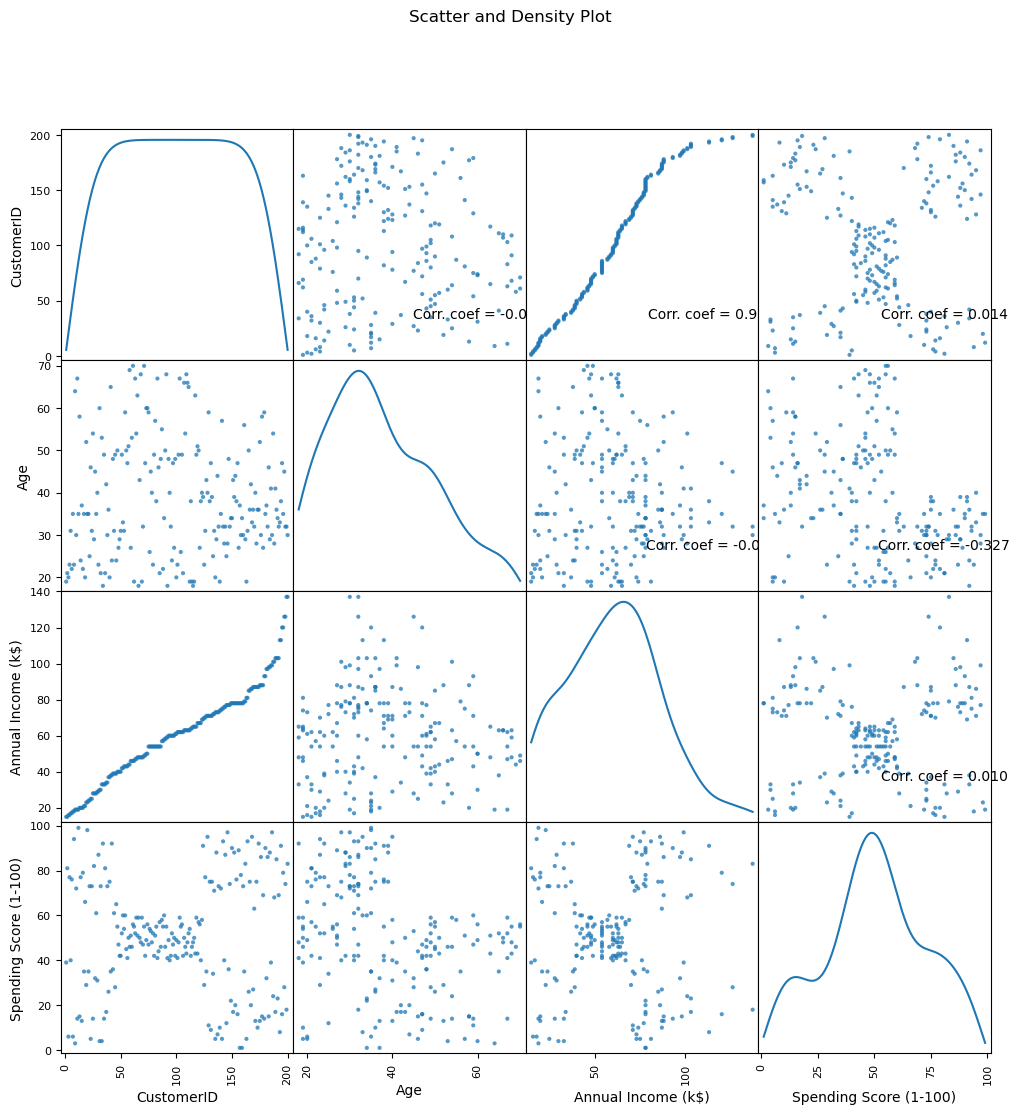

In [8]:
plotScatterMatrix(df, 12, 10)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


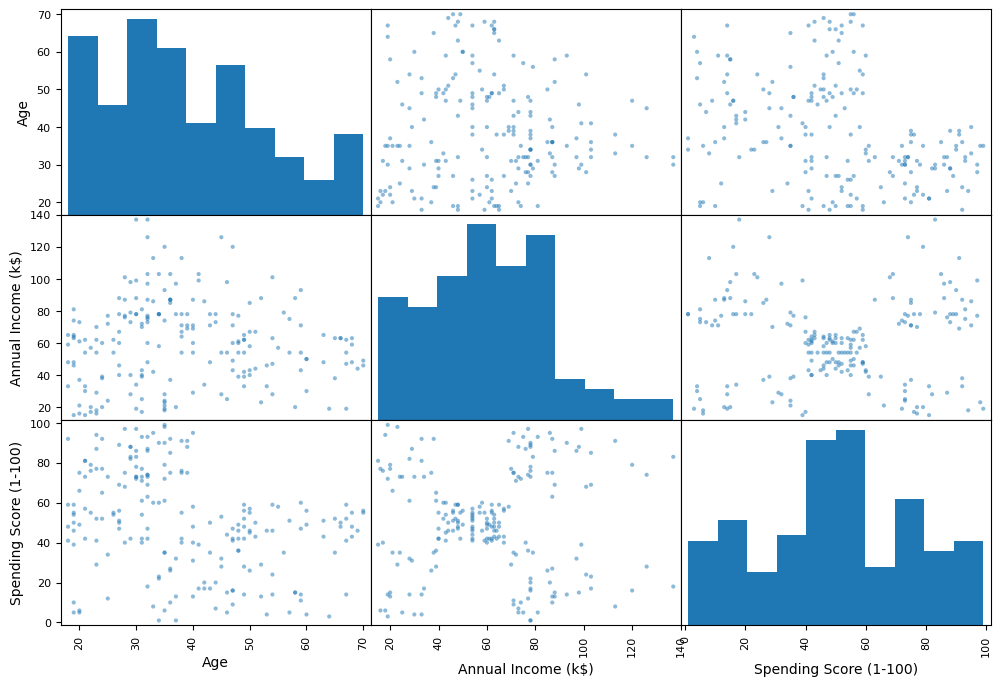

In [10]:
#histogram
attributes = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

from pandas.plotting import scatter_matrix

scatter_matrix(df[attributes], figsize=(12, 8))
plt.show()

In [11]:
df_num = df.select_dtypes(include=['int64'])
df_cat = df.select_dtypes(include=['object'])

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [13]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = make_pipeline(
    SimpleImputer(strategy = "most_frequent"),
    OneHotEncoder()
)
cat_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder', OneHotEncoder())])

In [14]:
from sklearn.compose import make_column_transformer, make_column_selector

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

preprocessing

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7b9efcb66950>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7b9efcb64820>)])

In [15]:
df_input = preprocessing.fit_transform(df)

In [16]:
df_input.shape

(200, 6)

In [17]:
df_copy.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [18]:
preprocessing.get_feature_names_out()

array(['pipeline-1__CustomerID', 'pipeline-1__Age',
       'pipeline-1__Annual Income (k$)',
       'pipeline-1__Spending Score (1-100)', 'pipeline-2__Gender_Female',
       'pipeline-2__Gender_Male'], dtype=object)

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

cluster_range = range(2,10)
best_score = -1
best_cluster = None

for r in cluster_range:
    
    #initialzie kmeans with the cluster size $i
    #print('cluster size:',r)
    kmeans = KMeans(n_clusters=r, random_state=42)
    
    #fit input data
    kmeans.fit(df_input)
    
    #get labels
    labels = kmeans.labels_
    
    #get silhouette score
    score = silhouette_score(df_input, labels)
    
    #print("score : ", score)
    
    #get max score
    if score > best_score:
        best_score = score
        best_cluster = r

print('Best score is ==', best_score)
print('Best cluster size == ', best_cluster)
    
###now we have found best cluster size, rerun the kmeans with the best cluster size
kmeans = KMeans(n_clusters=best_cluster, random_state=42)
y_kmeans=kmeans.fit_predict(df_input)
y_kmeans

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

Best score is == 0.3439781660086294
Best cluster size ==  5


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([2, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2,
       3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 0, 2, 3, 2,
       3, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2,
       2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0,
       0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 1, 4, 1, 1, 4, 1, 4, 1, 4, 1, 4, 1,
       4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1,
       4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1,
       4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1,
       4, 1], dtype=int32)

In [20]:
df = df_copy.copy()
df['cluster'] = y_kmeans
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,Male,19,15,39,2
1,2,Male,21,15,81,2
2,3,Female,20,16,6,3
3,4,Female,23,16,77,2
4,5,Female,31,17,40,3


In [21]:
df = df.drop('CustomerID', axis=1)

In [22]:
df.select_dtypes(include=[np.number]).groupby('cluster').mean()

,Age,Annual Income (k$),Spending Score (1-100)
cluster,,,
0,55.255319,54.063830,49.000000
1,32.731707,85.634146,80.902439
2,25.038462,41.057692,62.788462
3,45.523810,26.285714,19.380952
4,40.333333,86.487179,19.179487
